In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [4]:
pip install -U scikit-learn

In [5]:
# Load the dataset
file_path = "/content/time series data.zip"
df = pd.read_csv(file_path)
print(df)

           Date        Asset   Price
0    2023-07-10       Bond B  385.64
1    2023-03-03      Stock B  297.20
2    2023-09-13       Bond B   75.98
3    2023-01-07       Bond B  356.34
4    2023-06-04      Stock A  260.05
..          ...          ...     ...
495  2023-03-30      Stock B  278.00
496  2023-06-27       Bond A  224.26
497  2023-07-16  Commodity A  457.96
498  2023-11-03       Bond B   57.23
499  2023-09-24  Commodity A  401.98

[500 rows x 3 columns]


In [6]:
# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Select a single asset for ARIMA (choosing the most frequent one)
most_common_asset = df['Asset'].value_counts().idxmax()
df_asset = df[df['Asset'] == most_common_asset]

In [7]:
# Sort by date
df_asset = df_asset.sort_values(by='Date')

# Set 'Date' as the index for time series analysis
df_asset.set_index('Date', inplace=True)

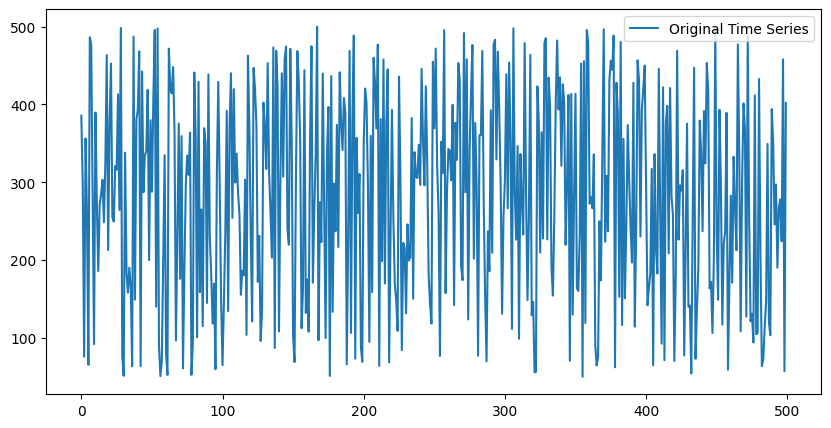

ADF Statistic: -23.03778553104883
p-value: 0.0
The series is stationary (Reject H0)


In [8]:
# Plot the time series
plt.figure(figsize=(10,5))
plt.plot(df["Price"], label="Original Time Series")
plt.legend()
plt.show()

# Perform ADF Test
adf_test = adfuller(df["Price"])
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")

# Interpret results
if adf_test[1] < 0.05:
    print("The series is stationary (Reject H0)")
else:
    print("The series is non-stationary (Fail to reject H0)")

In [9]:
# Split data into training and testing sets (80% train, 20% test)
train_size = int(len(df_asset) * 0.8)
train, test = df_asset.iloc[:train_size], df_asset.iloc[train_size:]

In [10]:
# Fit ARIMA model on training data
model = ARIMA(train['Price'], order=(2, 1, 2))  # AR(2), Differencing(1), MA(2)
model_fit = model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [11]:
# Forecast future prices (next 10 time steps)
forecast_steps = 10
forecast = model_fit.forecast(steps=forecast_steps)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [12]:
# Ensure forecast length matches test set
min_len = min(len(test['Price']), len(forecast))
actual_values = test['Price'].iloc[:min_len]  # Trim test values to match forecast length
predicted_values = forecast[:min_len]  # Trim forecast if necessary

In [13]:
print(f"Length of actual_values: {len(actual_values)}")
print(f"Length of predicted_values: {len(predicted_values)}")


Length of actual_values: 10
Length of predicted_values: 10


In [14]:
# Select the last 10 actual prices for comparison
actual_values = test['Price'].iloc[:forecast_steps].reset_index(drop=True).values
predicted_values = forecast.iloc[:forecast_steps].reset_index(drop=True).values

In [15]:
# Compute performance metrics
mae = mean_absolute_error(actual_values, predicted_values)
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100

In [16]:
# Display results
print("\nModel Performance Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Model Performance Metrics:
Mean Absolute Error (MAE): 97.7094
Root Mean Squared Error (RMSE): 121.5679
Mean Absolute Percentage Error (MAPE): 56.84%


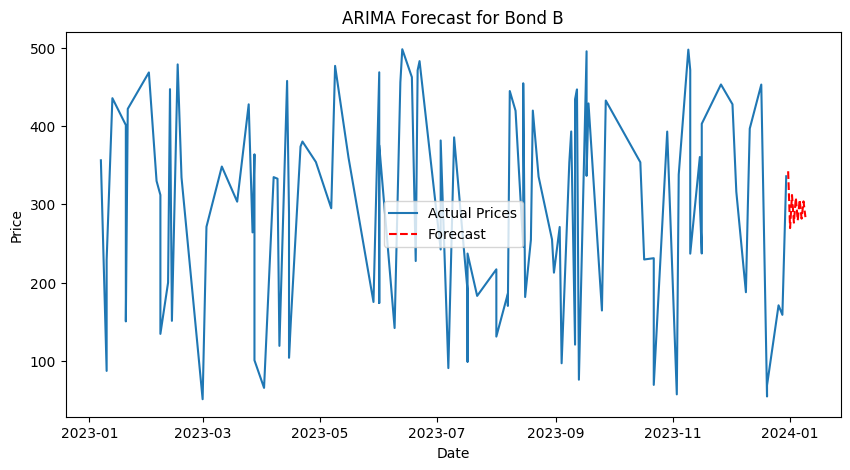

In [17]:
# Plot the original data and forecasted values
plt.figure(figsize=(10, 5))
plt.plot(df_asset.index, df_asset['Price'], label="Actual Prices")
plt.plot(pd.date_range(df_asset.index[-1], periods=forecast_steps+1, freq='D')[1:], forecast,
         label="Forecast", linestyle="dashed", color='red')
plt.xlabel("Date")
plt.ylabel("Price")
plt.title(f"ARIMA Forecast for {most_common_asset}")
plt.legend()
plt.show()

In [18]:
# Display the forecasted values
print("Forecasted Prices:")
print(forecast)

Forecasted Prices:
88    342.325083
89    269.714776
90    311.979848
91    276.661394
92    308.461708
93    279.489198
94    305.932248
95    281.791430
96    303.831327
97    283.709395
Name: predicted_mean, dtype: float64
